## II- clustering

In [266]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn import datasets
from sklearn.cluster import KMeans

In [267]:
df_indicateurs = pd.read_csv(r'C:\Users\orlya\Desktop\Projet 9\indicateur_pays_2017.csv')

In [268]:
df_indicateurs.head()

,pays,population_milliers_hab,evolution_moyenne_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
0,Afghanistan,36296.113,3.29,0.42,50.88,1.53,4.865789,537.126294,-2.80
1,Afrique du Sud,57009.756,1.40,6.41,24.27,35.69,17.703799,6537.504869,-0.28
2,Albanie,2884.169,-0.45,1.29,74.51,16.36,9.765943,4532.791977,0.38
3,Algérie,41389.189,1.72,0.80,0.72,6.38,6.287892,4081.775086,-0.92
4,Allemagne,82658.409,0.12,2.06,49.24,19.47,6.441276,45734.557501,0.59


Les algorithmes de clustering que nous allons utiliser dans la suite de cette étude nécessitent que nous ne leur fournissions que les valeurs numériques des indicateurs. nous supprimons donc les pays

In [269]:
X = df_indicateurs.drop('pays', axis='columns')

**Nous allons également normaliser les données, c'est à dire les réduire puis les centrer. La réduction va gommer les différences d'échelles entre variables et la centralisation va recentrer les variables autour de 0 ce qui facilitera la visualisation et l'interprétation des résultats.**

In [270]:
# Standardise les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:2])

[[-0.04443898  1.56843662 -1.02862853  0.19784825 -1.19062167 -0.4435052
  -0.72829183 -3.05950463]
 [ 0.09051559  0.02232787  1.3752188  -0.36670685  0.9675434   1.49418143
  -0.39709035 -0.23729244]]


La dernière étape consiste à créer deux listes : une contenant les pays, une autre contenant les indicateurs.

In [271]:
pays = df_indicateurs['pays'].to_numpy()

indicateurs = df_indicateurs.drop(columns='pays').columns.to_numpy()

### 2. Analyse des Composantes Principales (ACP)


##### 2.1. Choix du nombre de dimensions

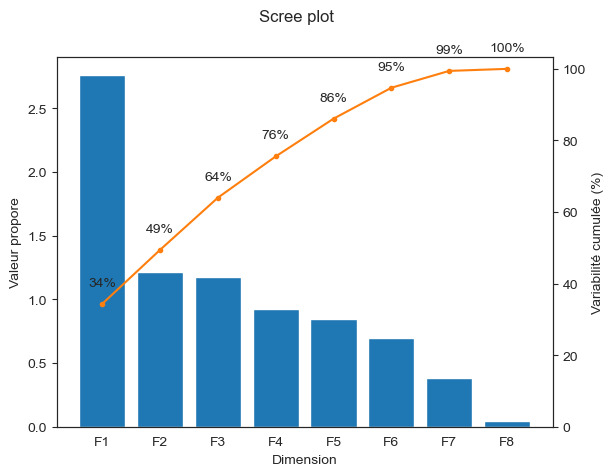

In [272]:
# Effectue la décomposition sur toutes les dimensions
pca = PCA()
pca = pca.fit(X_scaled)

# Initialse les variables
components = np.arange(1, (len(pca.explained_variance_)+1))
components = [f'F{x}' for x in components]

cum_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Trace les graphiques
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))
ax2 = ax1.twinx()

ax1.bar(components, pca.explained_variance_,)
ax2.plot(components, cum_variance_ratio, color='C1', marker='.')
for x, y in enumerate(cum_variance_ratio):
    ax2.text(x, (y+0.05) , f'{y:.0%}', ha='center')

# Définit la limite basse et le format de l'axe secondaire
ax2.set_ylim(bottom=0)
ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: round(x*100))
)

ax1.set_xlabel('Dimension')
ax1.set_ylabel('Valeur propore')
ax2.set_ylabel('Variabilité cumulée (%)')

fig.suptitle('Scree plot')

plt.show()



In [273]:
pcs = pca.components_
pcs

array([[-0.13052618, -0.24265401,  0.47605652,  0.24272785,  0.52658852,
        -0.07553983,  0.38646971,  0.45406471],
       [ 0.36899545, -0.55975026, -0.29231343, -0.20797414, -0.14070359,
         0.52091931,  0.24327422,  0.26736649],
       [ 0.47586574, -0.13526205,  0.39042873, -0.56895288,  0.35603352,
        -0.14232275, -0.23342535, -0.27858747],
       [ 0.43928712, -0.01656683, -0.25514265,  0.04963608, -0.18432766,
        -0.74334431,  0.36586771,  0.13709207],
       [ 0.60165239,  0.54719934,  0.12926084,  0.38858397,  0.09037011,
         0.36884192,  0.15452788, -0.05283404],
       [ 0.23265594, -0.47738855,  0.04546321,  0.61916935, -0.02557041,
        -0.10995516, -0.55996499, -0.07892413],
       [-0.10586275, -0.27405663, -0.02483356,  0.19178361,  0.09915472,
         0.04050977,  0.49792146, -0.78542339],
       [ 0.00791147, -0.0824282 ,  0.67156438, -0.02257629, -0.72354559,
         0.01856723,  0.13321713, -0.004983  ]])

In [274]:
pcs = pd.DataFrame(pcs)
test = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,-0.130526,-0.242654,0.476057,0.242728,0.526589,-0.075540,0.386470,0.454065
1,0.368995,-0.559750,-0.292313,-0.207974,-0.140704,0.520919,0.243274,0.267366
2,0.475866,-0.135262,0.390429,-0.568953,0.356034,-0.142323,-0.233425,-0.278587
3,0.439287,-0.016567,-0.255143,0.049636,-0.184328,-0.743344,0.365868,0.137092
4,0.601652,0.547199,0.129261,0.388584,0.090370,0.368842,0.154528,-0.052834
5,0.232656,-0.477389,0.045463,0.619169,-0.025570,-0.109955,-0.559965,-0.078924
6,-0.105863,-0.274057,-0.024834,0.191784,0.099155,0.040510,0.497921,-0.785423
7,0.007911,-0.082428,0.671564,-0.022576,-0.723546,0.018567,0.133217,-0.004983


In [275]:
features = X.columns
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,population_milliers_hab,evolution_moyenne_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
F1,-0.13,-0.24,0.48,0.24,0.53,-0.08,0.39,0.45
F2,0.37,-0.56,-0.29,-0.21,-0.14,0.52,0.24,0.27
F3,0.48,-0.14,0.39,-0.57,0.36,-0.14,-0.23,-0.28
F4,0.44,-0.02,-0.26,0.05,-0.18,-0.74,0.37,0.14
F5,0.60,0.55,0.13,0.39,0.09,0.37,0.15,-0.05
F6,0.23,-0.48,0.05,0.62,-0.03,-0.11,-0.56,-0.08
F7,-0.11,-0.27,-0.02,0.19,0.10,0.04,0.50,-0.79
F8,0.01,-0.08,0.67,-0.02,-0.72,0.02,0.13,-0.00


In [276]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
population_milliers_hab,-0.130526,0.368995,0.475866,0.439287,0.601652,0.232656,-0.105863,0.007911
evolution_moyenne_population_pct,-0.242654,-0.559750,-0.135262,-0.016567,0.547199,-0.477389,-0.274057,-0.082428
consommation_volaille_pct,0.476057,-0.292313,0.390429,-0.255143,0.129261,0.045463,-0.024834,0.671564
tdi_pct,0.242728,-0.207974,-0.568953,0.049636,0.388584,0.619169,0.191784,-0.022576
disponibilite_kg_p_an,0.526589,-0.140704,0.356034,-0.184328,0.090370,-0.025570,0.099155,-0.723546
taux_croissance_pct,-0.075540,0.520919,-0.142323,-0.743344,0.368842,-0.109955,0.040510,0.018567
revenu_par_habitant_usd,0.386470,0.243274,-0.233425,0.365868,0.154528,-0.559965,0.497921,0.133217
indice_stabilite_politique,0.454065,0.267366,-0.278587,0.137092,-0.052834,-0.078924,-0.785423,-0.004983


Dans la partie précédente, nous n'avons pas pu représenter facilement nos résultats car le nombre de dimensions de notre jeu de données est un peu trop important (nous avons 8 indicateurs). En utilisant l'ACP, nous allons chercher à synthétiser les informations tout en réduisant le nombre de dimensions à analyser.

Les cinq premières dimension  correspondent à un pourcentage de variabilité de 86 %. La représentation sur cinq dimensions est donc de qualité suffisante, c'est ce nombre que nous choisissons de garder pour la suite.

##### 2.2. Cercles des Corrélations

**On étudie ensuite les liaisons entre nos variables d'origine et les composantes principales en nous aidant du cercle des corrélations grâceà une une fonction qui va nous permettre de tracer ce cercle en fonction des composantes principales que l'on souhaite afficher.**

In [277]:
pcs = pca.components_
pcs

array([[-0.13052618, -0.24265401,  0.47605652,  0.24272785,  0.52658852,
        -0.07553983,  0.38646971,  0.45406471],
       [ 0.36899545, -0.55975026, -0.29231343, -0.20797414, -0.14070359,
         0.52091931,  0.24327422,  0.26736649],
       [ 0.47586574, -0.13526205,  0.39042873, -0.56895288,  0.35603352,
        -0.14232275, -0.23342535, -0.27858747],
       [ 0.43928712, -0.01656683, -0.25514265,  0.04963608, -0.18432766,
        -0.74334431,  0.36586771,  0.13709207],
       [ 0.60165239,  0.54719934,  0.12926084,  0.38858397,  0.09037011,
         0.36884192,  0.15452788, -0.05283404],
       [ 0.23265594, -0.47738855,  0.04546321,  0.61916935, -0.02557041,
        -0.10995516, -0.55996499, -0.07892413],
       [-0.10586275, -0.27405663, -0.02483356,  0.19178361,  0.09915472,
         0.04050977,  0.49792146, -0.78542339],
       [ 0.00791147, -0.0824282 ,  0.67156438, -0.02257629, -0.72354559,
         0.01856723,  0.13321713, -0.004983  ]])

In [278]:
# Effectue la décomposition
pca = PCA(n_components=5)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
# xpca nouvelle df est ta nouvelle dataframe utilise xpca pour tous les clustering(appliquée les recommendations)

In [279]:
def acp_corr_circle_plot(x_d, y_d, pca=pca, text_offset=0.04):
    '''
    Trace le cercle des corrérations d'une ACP.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - pca : la décomposition effectuée.
    - text_offset : le décalage pour le positionnement des noms des
    indicateurs.
    '''

    # Initialise les variables
    eigenvectors = pca.components_.T
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])

    # Initialise le graphique
    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    ax.set_xlim(-1.02, 1.02)
    ax.set_ylim(-1.02, 1.02)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace le cercle et les axes en pointillés
    circle = plt.Circle((0, 0), 1, fill=False, linewidth=1, color='0.8')
    ax.add_patch(circle)
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

    # Représente les vecteurs
    for i in range(len(eigenvectors)):
        # Trace les flèches
        ax.annotate(
            text='',
            xy=(eigenvectors[i, x_d], eigenvectors[i, y_d]),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', linewidth=1, color='r')
        )

        # Paramètre la position texte (indicateurs)
        if eigenvectors[i, x_d] > 0:
            h_offset=text_offset
        elif eigenvectors[i, x_d] < 0:
            h_offset=-text_offset
        
        if eigenvectors[i, y_d] > 0:
            v_offset=text_offset
        elif eigenvectors[i, y_d] < 0:
            v_offset=-text_offset

        # Affiche les indicateurs
        ax.text(
            x=(eigenvectors[i, x_d]+h_offset), 
            y=(eigenvectors[i, y_d]+v_offset),
            s=indicateurs[i], fontsize='small'
        )

    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(
        f'Cercle des corrélations\n'
        f'Dimensions F{x_d + 1} et F{y_d + 1} ({cum_variance_ratio:.1%})'
        )

    plt.tight_layout()

    plt.show()

 **On trace le cercle pour les deux premières dimensions.**

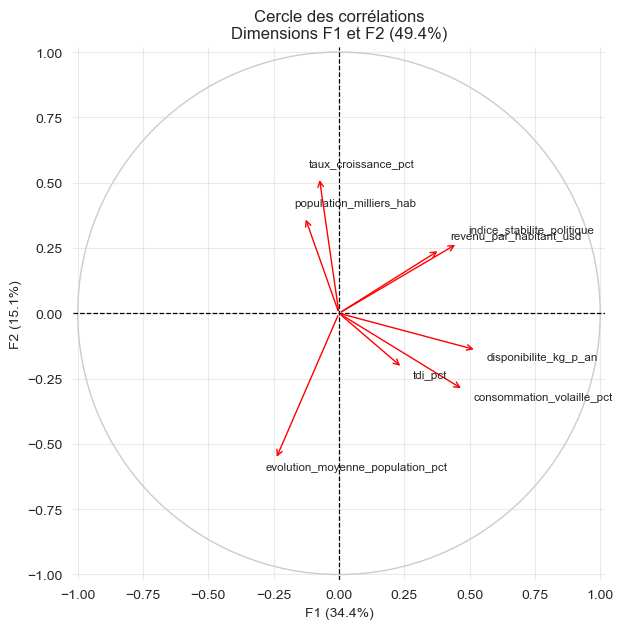

In [280]:
acp_corr_circle_plot(0, 1)

Les variables les plus corrélées à **F1** sont :

la disponibilité ;
la part de consommation de volaille ;
l'indice de stabilité politique ;
le revenu par habitant.

<br>Les variables les plus corrélées à **F2** sont :

le taux de croissance ;
l'évolution démographique.
On trace ensuite le cercle pour les deux autres composantes.

On trace ensuite le cercle  pour les deux autres composantes.

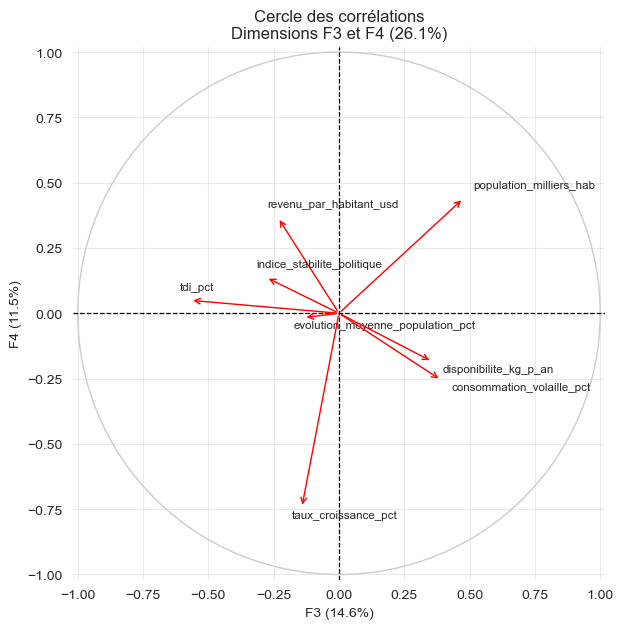

In [281]:
acp_corr_circle_plot(2, 3)

<br>Les variables les plus corrélées à **F3** sont :

le taux de dépendance aux importations ;
la taille de la population ;
la part de consommation de volaille ;
la disponibilité.
<br>Les variables les plus corrélées à **F4** sont :

le taux de croissance ;
la population ;
le revenu par habitant.

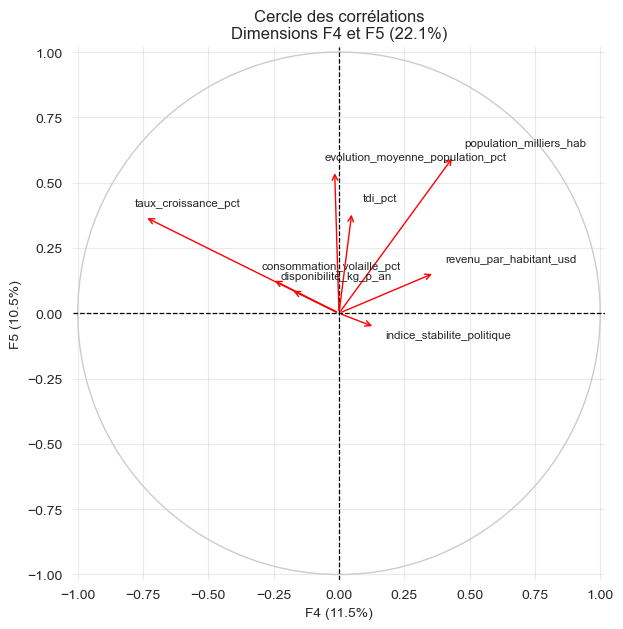

In [282]:
acp_corr_circle_plot(3, 4)

Les variables les plus corrélées à **F4** sont :
<br> population_milliers_hab et evolution_moyenne_population

La variable la plus corrélée à **F5** est :
<br> taux_croissance_pct

**On peut également afficher les corrélations sous forme de matrice.**

In [283]:
corr_indicateurs_pca = pd.DataFrame(
    np.transpose(pca.components_), index=indicateurs,
    columns=['F1', 'F2', 'F3', 'F4', 'F5'])

(corr_indicateurs_pca
 .style.background_gradient(axis='rows', cmap='RdYlBu').format('{:.2f}'))

,F1,F2,F3,F4,F5
population_milliers_hab,-0.13,0.37,0.48,0.44,0.60
evolution_moyenne_population_pct,-0.24,-0.56,-0.14,-0.02,0.55
consommation_volaille_pct,0.48,-0.29,0.39,-0.26,0.13
tdi_pct,0.24,-0.21,-0.57,0.05,0.39
disponibilite_kg_p_an,0.53,-0.14,0.36,-0.18,0.09
taux_croissance_pct,-0.08,0.52,-0.14,-0.74,0.37
revenu_par_habitant_usd,0.39,0.24,-0.23,0.37,0.15
indice_stabilite_politique,0.45,0.27,-0.28,0.14,-0.05


**La matrice confirme les observations faites sur les cercles des corrélations.**


In [284]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-3.08059022, -1.6934853 , -0.08590831,  0.09001123,  0.5533546 ],
       [ 0.68385683,  0.17733768,  1.07623651, -1.79653614,  0.69167159],
       [ 0.11795267,  0.99170412, -0.73989952, -0.17267836, -0.80844696],
       [-1.78221456, -0.10636319,  0.21493694,  0.17832512, -0.49742859],
       [ 1.08101073,  1.27074827, -0.58496671,  1.14355871, -0.2373018 ]])

In [285]:
# Création d'un DataFrame à l'aide des composantes principales
# Ajout du nom du pay ainsi que le groupe et le cluster associé par les methodes précédente (Dendrogramme & K-Means)

# Supposons X_proj contient les composantes principales
df_acp = pd.DataFrame(X_proj, columns=[f'PC{i+1}' for i in range(X_proj.shape[1])])

# Ajouter le nom des pays à partir du DataFrame original
df_acp['pays'] = df_indicateurs.index  # Assurez-vous que df_indicateurs contient la liste des pays



In [286]:
del corr_indicateurs_pca

#### 2.3. Représentation des individus sur les plans factoriels

Maintenant que nous avons créé de nouvelles variables, nous pouvons projeter les pays sur des plans composés par ces dernières. On crée une autre fonction qui va nous permettre de choisir les dimensions qui vont composer le plan que l'on souhaite représenter.

In [287]:
def acp_observations_plot(x_d, y_d, labels, pca=pca, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - labels : la liste des noms des individus
    - pca : la décomposition effectuée.
    - text_offset : le décalage pour le positionnement des noms des
    indicateurs.
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])

    fig, ax = plt.subplots(figsize=(15, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)
    
 # Trace les lignes en pointillés pour x = 0  et y = 0
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

    # Affiche la position des individus
    ax.scatter(X_pca[:, x_d], X_pca[:, y_d], marker='.')

    # Ajoute les noms des individus
    for i in range(len(X_pca)):
        ax.text(
            x=(X_pca[i, x_d]+text_offset),
            y=(X_pca[i, y_d]+text_offset),
            s=labels[i], fontsize=20
        )
    
    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} '
                 f'({cum_variance_ratio:.1%})')

    plt.tight_layout()

    plt.show()

In [288]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[-3.08059022, -1.6934853 , -0.08590831,  0.09001123,  0.5533546 ],
       [ 0.68385683,  0.17733768,  1.07623651, -1.79653614,  0.69167159],
       [ 0.11795267,  0.99170412, -0.73989952, -0.17267836, -0.80844696],
       [-1.78221456, -0.10636319,  0.21493694,  0.17832512, -0.49742859],
       [ 1.08101073,  1.27074827, -0.58496671,  1.14355871, -0.2373018 ]])

In [289]:
# Création d'un DataFrame à l'aide des composantes principales
# Ajout du nom du pay ainsi que le groupe et le cluster associé par les methodes précédente (Dendrogramme & K-Means)

# Création d'un DataFrame à l'aide des composantes principales
# Ajout du nom du pay ainsi que le groupe et le cluster associé par les methodes précédente (Dendrogramme & K-Means)

# Supposons X_proj contient les composantes principales
df_acp = pd.DataFrame(X_proj, columns=[f'PC{i+1}' for i in range(X_proj.shape[1])])



On va choisir de projecter nos pays sur un plan composé de F1 et de F3. En effet :

**plus un pays aura une valeur élevée sur F1,
<br> plus il aura une appétence pour le poulet tout en étant économiquement développé et fiable ;
plus un pays aura faible valeur sur F3,
<br> plus aura besoin d'importer pour satisfaire ses besoins.
Cela devrait donc nous permettre d'identifier des pays intéressants pour notre objectif.**

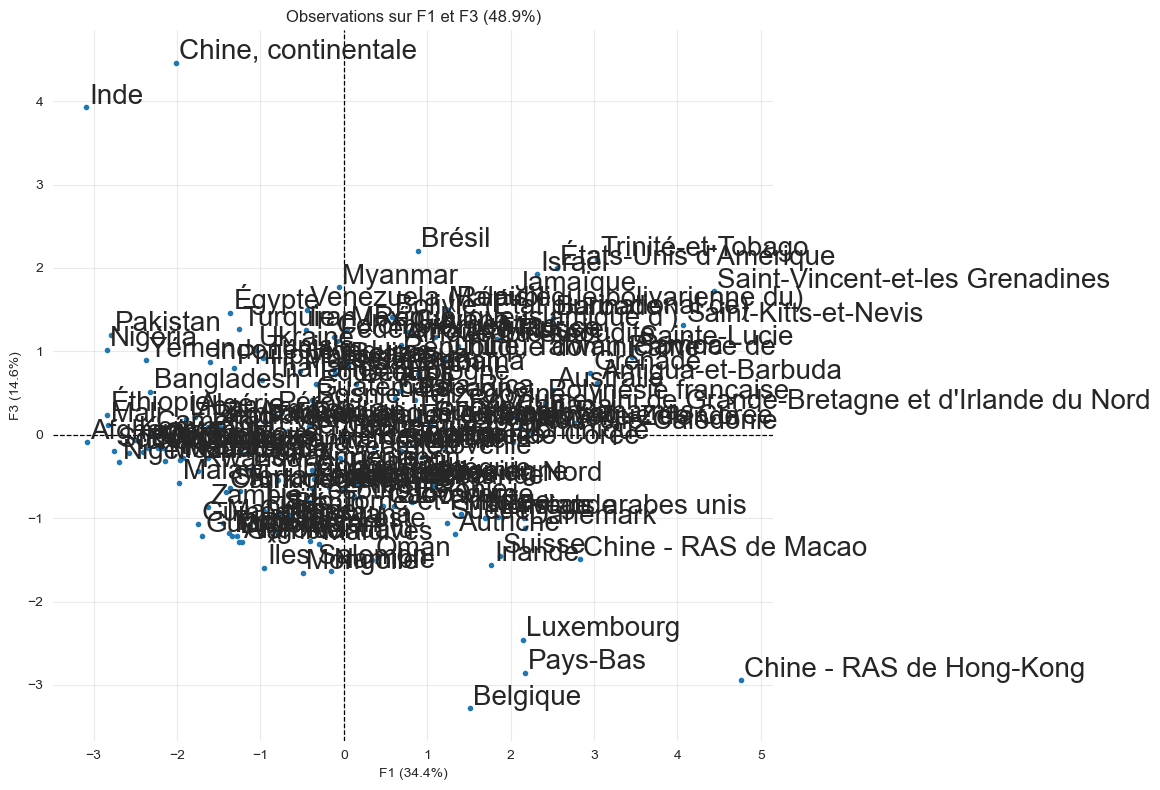

In [290]:
acp_observations_plot(0, 2, pays)

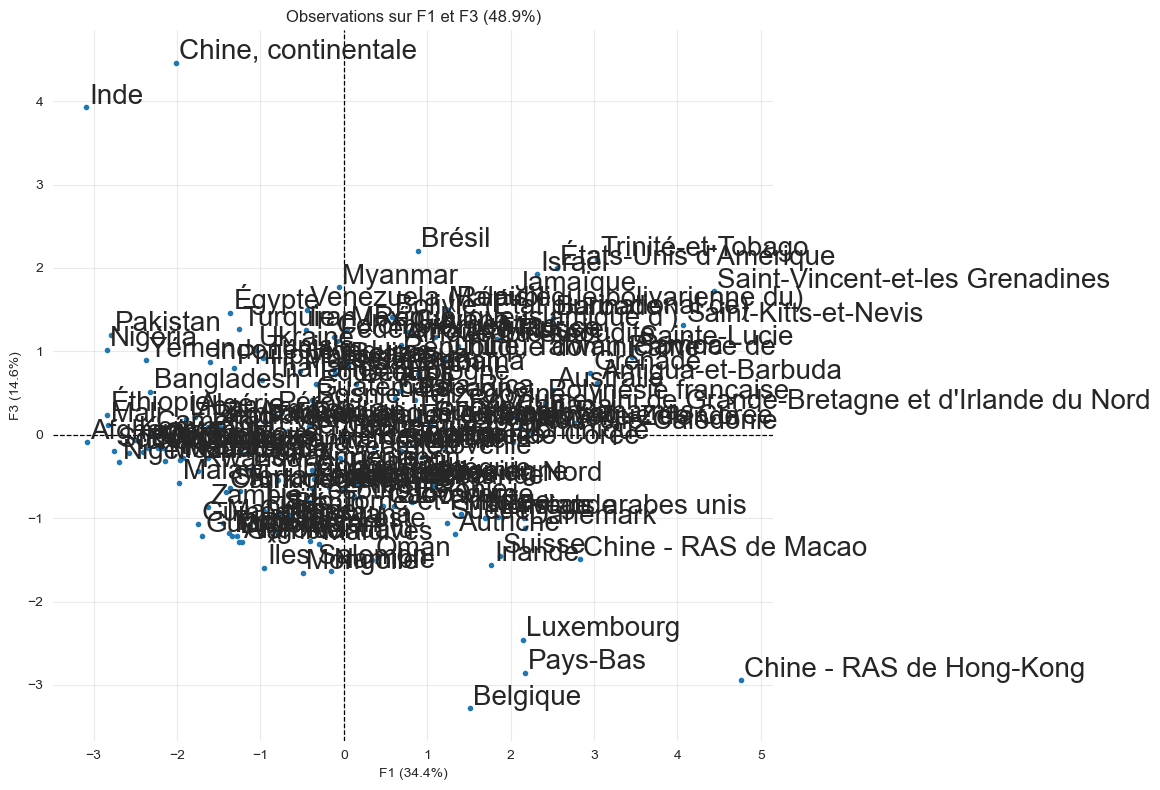

In [291]:
acp_observations_plot(0, 2, pays)

In [292]:


def acp_observations_plot(x_d, y_d, labels, X_pca, pca=pca, centroids=None, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP.
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - labels : la liste des noms des individus.
    - X_pca : les données transformées par PCA.
    - pca : la décomposition effectuée.
    - centroids : les coordonnées des centroïdes à afficher.
    - text_offset : le décalage pour le positionnement des noms des individus.
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])

    fig, ax = plt.subplots(figsize=(15, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    ax.scatter(X_pca[:, x_d], X_pca[:, y_d], marker='.', label='Observations', alpha=0.6)

    # Ajoute les noms des individus
    for i in range(len(X_pca)):
        ax.text(
            x=(X_pca[i, x_d] + text_offset),
            y=(X_pca[i, y_d] + text_offset),
            s=labels[i], fontsize=10
        )

    # Ajoute les centroïdes s'ils sont fournis
    if centroids is not None:
        ax.scatter(
            centroids[:, x_d],
            centroids[:, y_d],
            s=300,
            c='red',
            marker='X',
            label='Centroids'
        )
        for i, (cx, cy) in enumerate(centroids):
            ax.text(
                x=(cx + text_offset),
                y=(cy + text_offset),
                s=f'Centroid {i}',
                fontsize=12,
                fontweight='bold',
                color='red'
            )

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} '
                 f'({cum_variance_ratio:.1%})')

    plt.tight_layout()
    plt.legend()

    plt.show()

In [293]:
acp_observations_plot(0, 2, pays)


TypeError: acp_observations_plot() missing 1 required positional argument: 'X_pca'

In [ ]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

In [ ]:
fig, axes = plt.subplots(figsize=(14, 16))
axes.set_xlim(-5, 7)
axes.set_ylim(-7, 5)

# Tracé des points des individus selon les clusters
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters, cmap='Set1', label='Individus')

# Tracé des centroides des clusters
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='blue', marker='X', s=300, label='Centroides')

# Ajout des axes et des autres éléments de visualisation
plt.plot([-5, 7], [0, 0], color='black', linestyle='-', linewidth=0.5)
plt.plot([0, 0], [-7, 5], color='black', linestyle='-', linewidth=0.5)

plt.xlabel('F{} ({}%)'.format(1, round(100 * pca.explained_variance_ratio_[0], 1)))
plt.ylabel('F{} ({}%)'.format(2, round(100 * pca.explained_variance_ratio_[1], 1)))
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.legend()

plt.savefig('P5_graph/projection_des_individus_et_centroides_sur_1er_plan_factoriel.png')
plt.show()

Sur la zone située à droite du plan, et avec une valeur sur F3 assez faible, on retouve des pays que nous pourrions cibler. Pour confirmer cela, nous crées et affichées des projection  en affichant les clusters créés grâce à la CAH et a la  k-means.

## 2. Classification Ascendante  Hierarchique (CAH)

In [ ]:
# Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward

Z = linkage(X_scaled, method = 'ward', metric='euclidean')

In [ ]:
# Configuration de la figure
fig = plt.figure(figsize=(20, 10))
sns.set_style('white')

# Titre et étiquette
plt.title('Classification ascendante hiérarchique avec un dendrogramme', fontsize=20)
plt.ylabel('Distance', fontsize=10)

# Dendrogramme avec orientation modifiée
dendrogram(Z, labels=df_indicateurs.index, leaf_font_size=10, color_threshold=7, orientation='right')

# Sauvegarde de la figure
plt.savefig("dendrogramme.png")
plt.show()

In [ ]:
# Coupage du dendrogramme en 5 groupes pour avoir une première idée du partitionnement

fig = plt.figure(figsize=(30,10))
plt.title('Classification ascendante hiérarchique avec un dendrogramme - 5 clusters', fontsize=20)
plt.xlabel('Distance', fontsize=15)


dendrogram(Z, labels = df_indicateurs.index, p=5, truncate_mode='lastp', leaf_font_size=15, orientation='left')
plt.savefig("dendrogramme_clusters5.png")
plt.show()

In [ ]:
# Identification des 5 groupes obtenus
groupes_cah = fcluster(Z, 5, criterion='maxclust')
print('Numérotation de nos groupes : ' + str(np.unique(groupes_cah)))

# Index trié des groupes
idg = np.argsort(groupes_cah)

# Affichage des pays selon leurs groupes
df_pays_groupe = pd.DataFrame(df_indicateurs.index[idg], groupes_cah[idg]).reset_index()
df_pays_groupe = df_pays_groupe.rename(columns={'index':'Groupe'})

In [ ]:
# Intégration des groupes dans nos données de départ représenté par le dataframe "data"
# Jointure interne nécessaire pour parvenir à agréger nos données

df_groupes_cah = pd.merge(df_indicateurs, df_pays_groupe, on='pays')

In [ ]:
# Intégration des groupes dans nos données de départ représenté par le dataframe "data"
# Jointure interne nécessaire pour parvenir à agréger nos données

df_groupes_cah = pd.merge(df_indicateurs, df_pays_groupe, on='pays')

In [ ]:
# Préparation de sous-ensembles permettant de caractériser les groupes un à un

df_groupe1_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 1]
df_groupe2_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 2]
df_groupe3_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 3]
df_groupe4_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 4]
df_groupe5_cah = df_groupes_cah[df_groupes_cah['Groupe'] == 5]

 Nous allons utiliser est la classification ascendante hiérarchique qui consiste à regrouper, de manière itérative, les individus (ici les pays), à partir de la « distance » qui les sépare. Les distances entre individus sont regroupées dans une matrice calculée à partir des données initiales.

Nous allons calculer la matrice des distances, aussi appelée matrice de liaison, puis tracer le résultat des différentes itérations sous forme d'un dendrogramme.

In [ ]:
# Calcule la matrice de liaison
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Trace le dendogramme
fig, ax = plt.subplots(figsize=(15, 8))
plt.axhline( y = 13, color = 'r', linestyle = '--')

dn = dendrogram(Z, no_labels=True, orientation='top', ax=ax)

ax.set_title('Dendrogramme CAH')
ax.set_xlabel('Pays')
ax.set_ylabel('Distance')

plt.show()

del  fig, ax, dn

In [ ]:
# Initialise les variables
n_clusters_range = range(2, 21)
silhouette_avg_scores = []

# Calcule le score de Silhouette moyen pour chaque valeur du nombre de clusters
for n_clusters in n_clusters_range:
    clustering = fcluster(Z, t=n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_scaled, clustering)
    silhouette_avg_scores.append(silhouette_avg)

# Trace le graphique
fig, ax = plt.subplots()

plt.plot(n_clusters_range, silhouette_avg_scores, marker='.')
plt.axhline(y=silhouette_avg_scores[11], linestyle = '--', color='r')

# Définit la position des graduations
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de Silhouette moyen')
ax.set_title('Méthode du score de Silhouette')

plt.show()

del (n_clusters_range, silhouette_avg_scores, n_clusters, clustering,
     silhouette_avg, fig, ax)


On cherche ensuite la distance (en ordonnée) à laquelle couper le dendrogramme de manière à former les clusters. Cependant, le choix de la distance par lecture visuelle est subjective, d'autant plus avec le nombre d'individus présents dans nos données.

Pour choisir un nombre de clusters de manière plus objective, nous allons nous appuyer sur le coefficient de Silhouette qui rend compte de la qualité d'un regroupement. Il mesure à quel point les individus d'un même groupe sont similaires entre eux par rapport aux objets des autres groupes.
on remarque que le dernier cluster comporte environ 50% des pays et le cluster 3 ne contient que 2 pays le cluster 1 et 2 comporte a peut pret le meme nombre de pays et le cluster 4 comporte 20 % de l'efffectifs pays.

In [ ]:
# Identification des 5 groupes obtenus
groupes_cah = fcluster(Z, 5, criterion='maxclust')
print('Numérotation de nos groupes : ' + str(np.unique(groupes_cah)))

# Index trié des groupes
idg = np.argsort(groupes_cah)

# Affichage des pays selon leurs groupes
df_pays_groupe = pd.DataFrame(data.index[idg], groupes_cah[idg]).reset_index()
df_pays_groupe = df_pays_groupe.rename(columns={'index':'Groupe'})

In [ ]:
 #Initialise le nombre de clusters
n_clusters = 5

# Effectue le clustering
clustering = fcluster(Z, t=n_clusters, criterion='maxclust')

Le résultat du clustering est un array qui va nous servir à associer les groupes calculés avec le DataFrame contenant les indicateurs par pays.

In [ ]:
df_indicateurs['cluster_cah'] = clustering

In [ ]:
df_indicateurs

**Cela nous permet notamment d'affiche les pays qui composent chaque groupe.**

In [ ]:
# Crée la liste des clusters triés par ordre croissant
clusters = np.sort(df_indicateurs['cluster_cah'].unique())

# Liste les pays de chaque cluster et les affiche
for cluster in clusters:
    n_pays = len(
        df_indicateurs.loc[df_indicateurs['cluster_cah'] == cluster, 'pays'])
    liste_pays = list(
        df_indicateurs.loc[df_indicateurs['cluster_cah'] == cluster, 'pays'])

    print(f'Cluster {cluster} - {n_pays} pays')
    print(f'{liste_pays}')

del clusters, cluster, n_pays, liste_pays

In [ ]:
cah_clusters_statistics = (
    df_indicateurs.groupby('cluster_cah')[indicateurs].mean()
)

(cah_clusters_statistics
 .T.style.background_gradient(axis='columns').format('{:.2f}')
)

**On visualise assez bien ce qui caractérise chacun des groupes. Les clusters 1 à 4 ont une majorité d'indicateurs ayant des valeurs assez élevées. Nous pouvons retenir que ces derniers pour afficher un peu plus de détail grâce à une fonction qui nous permettra de reproduire le graphique avec les résultats des autres classifications. mais dans le soucis d'avoir une vue plus globale nous prendront aussi en compte le cluster 5.**



In [ ]:
def clusters_boxplot(clusters, clusters_retenus):
    '''
    Trace la dispersion des indicateurs pour chaque clusters.
    Paramètres :
    - clusters : la série contenant les clusters.
    - clusters_retenus : l'array contenant la liste des clusters à analyser.
    '''
    # Crée un DataFrame tempraire avec les clusters retenus
    df_temp = (
        df_indicateurs.loc[clusters.isin(clusters_retenus)]
    ).copy()

    # Trace le graphique pour chaque indicateur
    fig, axs = plt.subplots(3, 3, figsize=(9.6, 7.68))

    for i, indicateur in enumerate(indicateurs):
        r = i // 3
        c = i % 3
        sns.boxplot(data=df_temp, x=indicateur,
                    y=clusters.name, orient='h',
                    ax=axs[r, c], showfliers = False)
        
    # Supprime les graphiques vides
    [fig.delaxes(ax) for ax in axs.flatten() if not ax.has_data()]

    fig.suptitle('Dispersion des indicateurs')

    fig.tight_layout()

    plt.show()
    # maintenir les boxplot avec les variables de depard pour  comprende comment ils sont constitues 

In [ ]:
clusters_boxplot(df_indicateurs['cluster_cah'], [1, 2, 3, 4, 5])

###  2.1. Interpretations

**Groupe 1** : constitués majoritairement des iles il dispose d'une des plus faible population de tous les groupes  ce qui peut etre un frein dans notre objectif. il dispose aussi du taux de croissance le plus bas du revenu moyen par habitant tournant autour de 18000 USD ce qui lui donne la deuxieme place. il dispose du taux de consommation de poulet le plus élève, un bon taux indice de dépendance aux importations meme si en terme de logistique vue la situation géographique engendra des couts supplémentaire. il dispose de la moyenne de disponibilité alimentaire la  plus importante de tous les groupes et du deuxième indice de stabilité politique moyenne le plus élevé.



**Groupe 2** : Il dispose de la deuxieme population moyenne de tous les groupes avec des la moyenne de revenu moyenne la plus eleve par habitant autour de 48000 USD ce qui n'est pas surprenant car le groupe est constitué en majorité des pays les plus riches et industralisé du monde. le groupe dispose de la meilleur indice de stabilité politique moyenne avec la deuxieme consommation moyene de poulet parmis les autres groupes bien que disposant d'une évolution de population moynne la plus basse elle dispose aussi du deuxième taux moyen de dépendance au importation le plus éleve ce groupe present des atouts favorable a notre nouvelle objectif.



**Groupe 3** : contient la population la plus eleve ce qui est logique dans la mesure ou elle regroupe les deux pays les plus peuplé du monde. le groupe dispose aussi du taux de dépendance au importation moyen  le plus bas ce qui est un frein extrement important pour notre objectif d'importation. ce groupe dispose aussi des revenu moyen par habitant positionné en avant derniere position autour de 5000 USD l'indice de stabilité poitique moyenne bien que positif occupe les derneire place par rapoort au autres groupe par contre elle dispose du taux de croissance moyen le plus élevé.



**Groupe 4** : Contient la deuxième population la plus basse ainsi que  les revenu par habitant les plus bas tournant autour de 500 USD, il est constitué en majorité des pays africain. il dispose de la stabilité politique moyenne la plus basse de tous les autres groupes bien que disposant de l'évolution de la population moyenne la plus éleve de tous les groupes le taux de croissance et la consommation de volaille moyenne ferme la marche par rapoort à tous les autres groupes. son taux d'indice moyen au importation occupe la troisieme place. 



**Groupe 5** : Ce groupe contient des pays de divers continent ainsi que quelque iles son  indice de stabilité politique moyenne nègative ce qui est un frein non négligeable par rapport a notre futur objectif. il dispose aussi des revenu par habitant assez faibles par rapport au autre groupes occupant l'avant derniere place avec des revenu tournant autour de 4000 USD. il dsipose aussi du taux de consommation de vollaille le qui ferme faible. en plus d'avoir une stabilité politique moyenne instable et dispose aussi du deuxiele tauux de dépendance le plus bas.

**le groupe 2 regroupe les conditions les plus optimales pour deployer notre objectif d'importation de poulet**

In [ ]:
# faire un a un par groupe utiliser les valeur moyenne pour mieux comprendre faire des truc chiffre ex revenu avec la moyenne de revue 
clusters_retenus_cah = [2]

pays_retenus_cah = set(
    df_indicateurs.loc[df_indicateurs['cluster_cah'].isin([2]), 'pays']
)

In [ ]:
del n_clusters, clustering, cah_clusters_statistics, Z

In [294]:
df_indicateurs.head()

,pays,population_milliers_hab,evolution_moyenne_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
0,Afghanistan,36296.113,3.29,0.42,50.88,1.53,4.865789,537.126294,-2.80
1,Afrique du Sud,57009.756,1.40,6.41,24.27,35.69,17.703799,6537.504869,-0.28
2,Albanie,2884.169,-0.45,1.29,74.51,16.36,9.765943,4532.791977,0.38
3,Algérie,41389.189,1.72,0.80,0.72,6.38,6.287892,4081.775086,-0.92
4,Allemagne,82658.409,0.12,2.06,49.24,19.47,6.441276,45734.557501,0.59


## 3.  Classification K-means

 Nous allons utiliser est la classification k-means. Elle va regrouper les individus en cherchant à minimiser l'inertie intraclasse de chaque groupe. Pour cela, l'algorithme utilise les centres de gravité (centroïdes) des groupes. Au départ, les centroïdes sont placés aléatoirement puis, ils sont recaculés à chaque itération jusqu'à ce que les résultats de l'algorithme convergent.

Pour choisir le nombre optimal de clusters nous allons nous appuyer sur la méthode du coude dans laquelle nous allons calculer l'inertie intraclasse en fonction du nombre de groupes. On cherchera alors à déterminer à partir de quand l'augmentation du nombre de clusters n'a plus un impact significatif sur la diminution de l'inertie.

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

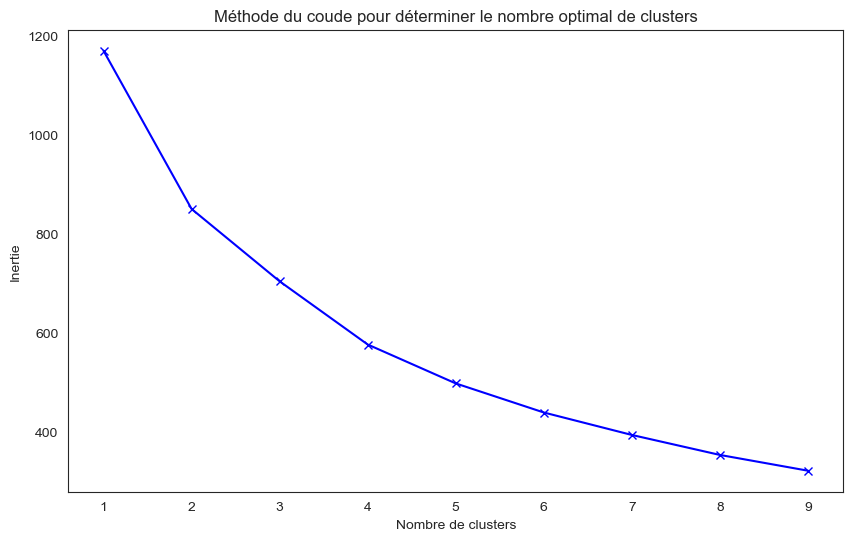

In [295]:
# Méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.show()

Le graphique montre une cassure à 5 clusters

In [296]:
# Initialise le nombre de clusters
n_clusters = 5

# Effectue le clustering
clustering = KMeans(n_clusters=n_clusters, n_init=10, init='random',
                    random_state=0)
clustering.fit(X_scaled)

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(init='random', n_clusters=5, n_init=10, random_state=0)

On associe nos groupes au DataFrame initial.

In [297]:
df_indicateurs['cluster_kmeans'] = clustering.labels_ + 1

Puis on affiche les pays qui composent chaque groupe.

In [ ]:
# Crée la liste des clusters triés par ordre croissant
clusters = np.sort(df_indicateurs['cluster_kmeans'].unique())

# Liste les pays de chaque cluster et les affiche
for cluster in clusters:
    n_pays = len(
        df_indicateurs.loc[df_indicateurs['cluster_kmeans'] == cluster, 'pays'])
    liste_pays = list(
        df_indicateurs.loc[df_indicateurs['cluster_kmeans'] == cluster, 'pays'])

    print(f'Cluster {cluster} - {n_pays} pays')
    print(f'{liste_pays}')

del clusters, cluster, n_pays, liste_pays

Enfin, on affiche les centroïdes des indicateurs, qui correspondent à leurs moyennes, grâce à l'attribut cluster_centers_. Pour récupérer les valeurs réelles non normalisées, on utilise la méthode inverse_transform() de StandardScaler().

In [ ]:
# Crée un DataFrame à partir des centroïdes avec les données non normalisées
kmeans_clusters_statistics = pd.DataFrame(
    scaler.inverse_transform(clustering.cluster_centers_)).T

# Définit les indicateurs comme index
kmeans_clusters_statistics = kmeans_clusters_statistics.set_index(indicateurs)

# Renomme les colonnes
kmeans_clusters_statistics.columns = kmeans_clusters_statistics.columns + 1

# Affiche le DataFrame
(kmeans_clusters_statistics
 .style.background_gradient(axis='columns').format('{:.2f}'))

In [ ]:
clusters_boxplot(df_indicateurs['cluster_kmeans'], [1, 2, 3, 4, 5])

### Interprétations 

**Groupe 1** : Contient la deuxième population la plus basse ainsi que  les revenu par habitant les plus bas tournant autour de 500 USD, il est constitué en majorité des pays africain. il dispose de la stabilité politique moyenne la plus basse de tous les autres groupes bien que disposant de l'évolution de la population moyenne la plus éleve de tous les groupes le taux de croissance et la consommation de volaille moyenne ferme la marche par rapoort à tous les autres groupes. son taux d'indice moyen au importation occupe la troisieme place. 


**Groupe 2** : constitués majoritairement des iles il dispose d'une des plus faible population de tous les groupes  ce qui peut etre un frein dans notre objectif ce groue dispose aussi du taux de croissance le plus bas et les revenu moyen par habitant tournent autour de 18000 USD. il dispose du taux de consommation de poulet le plus élève ainsi que le taux indice de dépendance aux importations meme si en terme de logistique vue la situation géographique cela engendra des couts supplémentaires. il dispose de la moyenne de disponibilité alimentaire la  plus importante de tous les groupes et du deuxième meilleur taux d' indice de stabilité politique moyenne.



**Groupe 3** : contient la deuxième population la plus eleve il dispose  du l'avant dernier taux de dépendance au importation moyen de 24%  ce qui est un frein extrement important pour notre objectif d'importation. ce groupe dispose aussi des revenu moyen par habitant positionné en avant derniere position autour de 5000 USD son indice de stabilité poitique moyenne autour de 0,2 et occupe la troisieme place.un très bon taux de croissance moyen de 9% occupant la deuxieme place.


**Groupe 4** : Il dispose de la deuxieme population moyenne avec des revenu moyenne de 50000 USD très loin devant tous les autres. cela n'est pas surprenant car le groupe est constitué en majorité des pays les plus riches et industralisé du monde.il  dispose d'un indice de stabilité politique moyenne de 1 il y a pas mieux. il dispose aussi du troisième taux de consommation moyene. Elle dispose d'une évolution de population moyenne à la troisième place autour de 1%. Elle dispose aussi du deuxième taux moyen de dépendance au importation autour de 37%  en plus d'etre des pays très proche et dans la meme organisation continentale pour la plus part ce groupe remplir les conditions pour notre objectif.


**Groupe 5** :  contient la population la plus eleve ce qui est logique dans la mesure ou elle regroupe les deux pays les plus peuplé du monde. le groupe dispose aussi du taux de dépendance au importation moyen de 2% le plus bas ce qui est un frein extrement important pour notre objectif d'importation. ce groupe dispose  des revenus moyens par habitants positionné en avant derniere position autour de 5000 USD l'indice de stabilité poitique moyenne autour de 0,5 bien que positif occupe la derniere elle dispose aussi du taux de croissance moyen le plus élevé. La disponibilité alimentaire moyenne se trouve encore une fois à l'avant derniere place autour de 9kg/personnes/an.

**le groupe 4 regroupe les conditions les plus optimales pour deployer notre objectif d'importation de poulet**

In [303]:
clusters_retenus_kmeans = [4]

pays_retenus_kmeans = set(
    df_indicateurs.loc[df_indicateurs['cluster_kmeans'].isin([4]), 'pays']
)

**Calcul des Centroides**

In [307]:

# Filtrer les colonnes numériques
numeric_cols = X.select_dtypes(include=[np.number]).columns
# Calculer les centroïdes pour CAH
#centroids_cah = df_indicateurs.groupby('cluster_cah')[numeric_cols].mean()
#centroids_cah_pca = pca.transform(centroids_cah)

# Calculer les centroïdes pour k-means
centroids_kmeans = X.groupby('cluster_kmeans')[numeric_cols].mean()
centroids_kmeans_pca = pca.transform(centroids_kmeans)

# Préparer les données pour le tracé
df_pca = pd.DataFrame(X_pca, columns=[f'F{i+1}' for i in range(X_pca.shape[1])])
#df_pca['cluster_cah'] = df_indicateurs['cluster_cah']
df_pca['cluster_kmeans'] = df_indicateurs['cluster_kmeans']


KeyError: 'cluster_kmeans'

**Fonction des tracés** 

In [ ]:
def acp_clusters_plot(x_d, y_d, clusters, centroids_pca, pca=pca, X_pca=X_pca):
    '''
    Trace le graphique des observations d'une ACP avec leur cluster.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - clusters : la série contenant les clusters.
    - centroids_pca : les coordonnées des centroïdes dans l'espace PCA.
    - pca : la décomposition effectuée.
    - X_pca : la matrice des individus avec les dimensions calculées
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca)
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['p', '+', '*', 'x']

    fig, ax = plt.subplots(figsize=(10, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0  et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(1, (n_clusters + 1)):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, x_d],
            df.loc[df['cluster'] == i, y_d],
            marker=markers[j], label=f'Cluster {i}'
        )

    # Ajoute les centroïdes
    ax.scatter(
        centroids_pca[:, x_d],
        centroids_pca[:, y_d],
        s=300,
        c='red',
        marker='X',
        label='Centroids'
    )

    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur F{x_d + 1} et F{y_d + 1}'
                 f' ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')

    plt.show()

In [ ]:

def acp_clusters_plot(x_d, y_d, clusters, cen, pca=None, labels=None, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP avec les clusters et les centroides.
    
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - clusters : les clusters attribués à chaque individu.
    - centroids : les coordonnées des centroides à afficher.
    - pca : la décomposition effectuée.
    - labels : la liste des noms des individus.
    - text_offset : le décalage pour le positionnement des noms des individus.
    '''

    # Vérifie si PCA est fourni
    if pca is not None:
        cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                              + pca.explained_variance_ratio_[y_d])
    else:
        cum_variance_ratio = 0.0

    fig, ax = plt.subplots(figsize=(15, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus par cluster
    for cluster in clusters.unique():
        ax.scatter(X_pca[clusters == cluster, x_d], 
                   X_pca[clusters == cluster, y_d], 
                   label=f'Cluster {cluster}', alpha=0.6)

    # Ajoute les noms des individus si des labels sont fournis
    if labels is not None:
        for i in range(len(X_pca)):
            ax.text(X_pca[i, x_d] + text_offset, X_pca[i, y_d] + text_offset, 
                    labels[i], fontsize=10)

    # Ajoute les centroides s'ils sont fournis
    if centroids is not None:
        ax.scatter(centroids[:, x_d], centroids[:, y_d], 
                   marker='X', s=300, c='red', label='Centroids')
        for i, (cx, cy) in enumerate(centroids):
            ax.text(cx + text_offset, cy + text_offset, 
                    f'Centroid {i}', fontsize=12, fontweight='bold', color='red')

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})' if pca else f'F{x_d + 1}')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})' if pca else f'F{y_d + 1}')
    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} ({cum_variance_ratio:.1%})' if pca else f'Observations')

    plt.tight_layout()
    plt.legend()

    plt.show()

In [ ]:
# Supposons que X_pca contient vos données transformées par PCA

# Tracé pour CAH avec les centroides
acp_clusters_plot(0, 2, df_indicateurs['clusters_retenus_cah'], centroids=centroids_cah_pca, pca=pca)
print(f'Clusters retenus avec la CAH : {clusters_retenus_cah}\n')

# Tracé pour k-means avec les centroides
acp_clusters_plot(0, 2, df_indicateurs['clusters_retenus_kmeans'], centroids=centroids_kmeans_pca, pca=pca)
print(f'Clusters retenus avec les k-means : {clusters_retenus_kmeans}')


In [ ]:

def acp_clusters_plot(x_d, y_d, clusters, centroids=None, pca=None, labels=None, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP avec les clusters et les centroides.
    
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - clusters : les clusters attribués à chaque individu.
    - centroids : les coordonnées des centroides à afficher.
    - pca : la décomposition effectuée.
    - labels : la liste des noms des individus.
    - text_offset : le décalage pour le positionnement des noms des individus.
    '''

    # Vérifie si PCA est fourni
    if pca is not None:
        cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                              + pca.explained_variance_ratio_[y_d])
    else:
        cum_variance_ratio = 0.0

    fig, ax = plt.subplots(figsize=(15, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus par cluster
    for cluster in clusters.unique():
        ax.scatter(X_pca[clusters == cluster, x_d], 
                   X_pca[clusters == cluster, y_d], 
                   label=f'Cluster {cluster}', alpha=0.6)

    # Ajoute les noms des individus si des labels sont fournis
    if labels is not None:
        for i in range(len(X_pca)):
            ax.text(X_pca[i, x_d] + text_offset, X_pca[i, y_d] + text_offset, 
                    labels[i], fontsize=10)

    # Ajoute les centroides s'ils sont fournis
    if centroids is not None:
        ax.scatter(centroids[:, x_d], centroids[:, y_d], 
                   marker='X', s=300, c='red', label='Centroids')
        for i, (cx, cy) in enumerate(centroids):
            ax.text(cx + text_offset, cy + text_offset, 
                    f'Centroid {i}', fontsize=12, fontweight='bold', color='red')

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})' if pca else f'F{x_d + 1}')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})' if pca else f'F{y_d + 1}')
    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} ({cum_variance_ratio:.1%})' if pca else f'Observations')

    plt.tight_layout()
    plt.legend()

    plt.show()

In [ ]:
acp_clusters_plot(0, 2, df_indicateurs['cluster_cah'], centroids=True, pca=True, labels=True, text_offset=0.04)

In [ ]:
acp_clusters_plot(0, 2, df_indicateurs['cluster_cah'])
print(f'Clusters retenus avec la CAH : {clusters_retenus_cah}\n')

In [ ]:
def acp_clusters_plot(x_d, y_d, clusters, centroids=None, pca=None, labels=None, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP avec les clusters et les centroides.
    
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - clusters : les clusters attribués à chaque individu.
    - centroids : les coordonnées des centroides à afficher.
    - pca : la décomposition effectuée.
    - labels : la liste des noms des individus.
    - text_offset : le décalage pour le positionnement des noms des individus.
    '''

    # Vérifie si PCA est fourni pour calculer la variance cumulée
    if pca is not None:
        cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                              + pca.explained_variance_ratio_[y_d])
    else:
        cum_variance_ratio = 0.0

    fig, ax = plt.subplots(figsize=(15, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus par cluster
    unique_clusters = clusters.unique()
    colors = plt.cm.Set1.colors[:len(unique_clusters)]
    for i, cluster in enumerate(unique_clusters):
        ax.scatter(X_pca[clusters == cluster, x_d], 
                   X_pca[clusters == cluster, y_d], 
                   label=f'Cluster {cluster}', color=colors[i], alpha=0.6)

    # Ajoute les noms des individus si des labels sont fournis
    if labels is not None:
        for i in range(len(X_pca)):
            ax.text(X_pca[i, x_d] + text_offset, X_pca[i, y_d] + text_offset, 
                    labels[i], fontsize=10)

    # Ajoute les centroides s'ils sont fournis
    if centroids is not None:
        ax.scatter(centroids[:, x_d], centroids[:, y_d], 
                   marker='X', s=300, c='red', label='Centroids')
        for i, (cx, cy) in enumerate(centroids):
            ax.text(cx + text_offset, cy + text_offset, 
                    f'Centroid {i}', fontsize=12, fontweight='bold', color='red')

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})' if pca else f'F{x_d + 1}')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})' if pca else f'F{y_d + 1}')
    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} ({cum_variance_ratio:.1%})' if pca else f'Observations')

    plt.tight_layout()
    plt.legend()

    plt.show()

In [232]:
acp_clusters_plot(0, 2, clusters, centroids=centroids, pca=pca, labels=df_indicateurs['pays'].values)

NameError: name 'clusters' is not defined

In [396]:
def acp_clusters_plot(x_d, y_d, clusters, centroids_pca, X_pca, labels=None):
    '''
    Trace le graphique des observations d'une ACP avec leur cluster et les centroïdes.
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - clusters : la série contenant les clusters.
    - centroids_pca : les coordonnées des centroïdes dans l'espace PCA.
    - X_pca : la matrice des individus avec les dimensions calculées.
    - labels : les étiquettes des points, optionnel.
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d] + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca)
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(n_clusters):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, x_d],
            df.loc[df['cluster'] == i, y_d],
            marker=markers[j], label=f'Cluster {i}'
        )

    # Ajoute les centroïdes
    ax.scatter(
        centroids_pca[:, x_d],
        centroids_pca[:, y_d],
        s=300,
        c='red',
        marker='X',
        label='Centroids'
    )

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur F{x_d + 1} et F{y_d + 1}'
                 f' ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')

    # Affichage des labels des points si fournis
    if labels is not None:
        for i, txt in enumerate(labels):
            ax.annotate(txt, (df.iloc[i, x_d], df.iloc[i, y_d]), fontsize=8)

    plt.show()

# Exemple pour le clustering CAH
# Calculer les centroïdes pour CAH
centroids_cah = df_indicateurs.groupby('cluster_cah')[numeric_cols].mean()
centroids_cah_pca = pca.transform(centroids_cah)

# Exemple pour le clustering k-means
# Calculer les centroïdes pour k-means
centroids_kmeans = df_indicateurs.groupby('cluster_kmeans')[numeric_cols].mean()
centroids_kmeans_pca = pca.transform(centroids_kmeans)

# Préparer les données pour le tracé
df_pca = pd.DataFrame(X_pca, columns=[f'F{i+1}' for i in range(X_pca.shape[1])])
df_pca['cluster_cah'] = df_indicateurs['cluster_cah']
df_pca['cluster_kmeans'] = df_indicateurs['cluster_kmeans']

# Tracé pour CAH
labels = df_indicateurs['country']
acp_clusters_plot(0, 1, df_pca['cluster_cah'], centroids_cah_pca, X_pca, labels=labels)
print(f'Clusters retenus avec la CAH : {df_pca["cluster_cah"].unique()}\n')

# Tracé pour k-means
acp_clusters_plot(0, 1, df_pca['cluster_kmeans'], centroids_kmeans_pca, X_pca, labels=labels)
print(f'Clusters retenus avec les k-means : {df_pca["cluster_kmeans"].unique()}')

C:\Users\orlya\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


ValueError: X has 10 features, but PCA is expecting 8 features as input.

In [308]:
def acp_clusters_plot(x_d, y_d, clusters, centroids_pca, labels=None):
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d] + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(n_clusters):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, f'PC{x_d + 1}'],
            df.loc[df['cluster'] == i, f'PC{y_d + 1}'],
            marker=markers[j], label=f'Cluster {i}'
        )

    # Ajoute les centroïdes
    ax.scatter(
        centroids_pca[:, x_d],
        centroids_pca[:, y_d],
        s=300,
        c='red',
        marker='X',
        label='Centroids'
    )

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'PC{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'PC{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur PC{x_d + 1} et PC{y_d + 1} ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')

    # Affichage des labels des points si fournis
    if labels is not None:
        for i, txt in enumerate(labels):
            ax.annotate(txt, (df.iloc[i, x_d], df.iloc[i, y_d]), fontsize=8)

    plt.show()

In [88]:
# Préparer les données pour le tracé
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['cluster_cah'] = df_indicateurs['cluster_cah']
df_pca['cluster_kmeans'] = df_indicateurs['cluster_kmeans']
labels = df_indicateurs['country']

# Calculer les centroïdes pour CAH
centroids_cah = df_indicateurs.groupby('cluster_cah')[numeric_cols].mean()
centroids_cah_pca = pca.transform(centroids_cah)

# Calculer les centroïdes pour k-means
centroids_kmeans = df_indicateurs.groupby('cluster_kmeans')[numeric_cols].mean()
centroids_kmeans_pca = pca.transform(centroids_kmeans)

# Tracé pour CAH
acp_clusters_plot(0, 1, df_pca['cluster_cah'], centroids_cah_pca, labels=labels)
print(f'Clusters retenus avec la CAH : {df_pca["cluster_cah"].unique()}\n')

# Tracé pour k-means
acp_clusters_plot(0, 1, df_pca['cluster_kmeans'], centroids_kmeans_pca, labels=labels)
print(f'Clusters retenus avec les k-means : {df_pca["cluster_kmeans"].unique()}')

KeyError: 'cluster_cah'

In [ ]:

def acp_clusters_plot(x_d, y_d, clusters, centroids_pca, pca, X_pca, labels=None):
    '''
    Trace le graphique des observations d'une ACP avec leur cluster et les centroïdes.
    Paramètres :
    - x_d : la dimension de l'ACP à représenter sur l'axe x.
    - y_d : la dimension de l'ACP à représenter sur l'axe y.
    - clusters : la série contenant les clusters.
    - centroids_pca : les coordonnées des centroïdes dans l'espace PCA.
    - pca : la décomposition effectuée.
    - X_pca : la matrice des individus avec les dimensions calculées.
    - labels : les étiquettes des points, optionnel.
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d] + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca)
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+', 'x']
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0 et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(n_clusters):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, x_d],
            df.loc[df['cluster'] == i, y_d],
            marker=markers[j], label=f'Cluster {i}'
        )

    # Ajoute les centroïdes
    ax.scatter(
        centroids_pca[:, x_d],
        centroids_pca[:, y_d],
        s=300,
        c='red',
        marker='X',
        label='Centroids'
    )

    # Ajoute les titres (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur F{x_d + 1} et F{y_d + 1}'
                 f' ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')

    # Affichage des labels des points si fournis
    if labels is not None:
        for i, txt in enumerate(labels):
            ax.annotate(txt, (df.iloc[i, x_d], df.iloc[i, y_d]), fontsize=8)

    plt.show()

# Assurez-vous que df_indicateurs est bien défini avec les données réelles
# Exemple : df_indicateurs = pd.read_csv('path_to_your_file.csv')

# Exemple pour le clustering CAH
# Calculer les centroïdes pour CAH
centroids_cah = df_indicateurs.groupby('cluster_cah')[numeric_cols].mean()
centroids_cah_pca = pca.transform(centroids_cah)

# Exemple pour le clustering k-means
# Calculer les centroïdes pour k-means
centroids_kmeans = df_indicateurs.groupby('cluster_kmeans')[numeric_cols].mean()
centroids_kmeans_pca = pca.transform(centroids_kmeans)

# Préparer les données pour le tracé
df_pca = pd.DataFrame(X_pca, columns=[f'F{i+1}' for i in range(X_pca.shape[1])])
df_pca['cluster_cah'] = df_indicateurs['cluster_cah']
df_pca['cluster_kmeans'] = df_indicateurs['cluster_kmeans']

# Tracé pour CAH
labels = df_indicateors['country']
acp_clusters_plot(0, 1, df_pca['cluster_cah'], centroids_cah_pca, pca, X_pca, labels=labels)
print(f'Clusters retenus avec la CAH : {df_pca["cluster_cah"].unique()}\n')

# Tracé pour k-means
acp_clusters_plot(0, 1, df_pca['cluster_kmeans'], centroids_kmeans_pca, pca, X_pca, labels=labels)
print(f'Clusters retenus avec les k-means : {df_pca["cluster_kmeans"].unique()}')

In [397]:
def acp_clusters_plot(x_d, y_d, clusters, centroids_pca, pca=pca, X_pca=X_pca):
    '''
    Trace le graphique des observations d'une ACP avec leur cluster.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - clusters : la série contenant les clusters.
    - centroids_pca : les coordonnées des centroïdes dans l'espace PCA.
    - pca : la décomposition effectuée.
    - X_pca : la matrice des individus avec les dimensions calculées
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca)
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['p', '+', '*', 'x']

    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0  et y = 0
    ax.axhline(y=0, linestyle='--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle='--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(1, (n_clusters + 1)):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, x_d],
            df.loc[df['cluster'] == i, y_d],
            marker=markers[j], label=f'Cluster {i}'
        )

    # Ajoute les centroïdes
    ax.scatter(
        centroids_pca[:, x_d],
        centroids_pca[:, y_d],
        s=300,
        c='red',
        marker='X',
        label='Centroids'
    )

    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur F{x_d + 1} et F{y_d + 1}'
                 f' ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')

    plt.show()

On projette nos groupes sur les dimensions F1 et F3 pour les deux méthodes de classification.

In [309]:
acp_clusters_plot(0, 2, df_indicateurs['cluster_cah'])
print(f'Clusters retenus avec la CAH : {clusters_retenus_cah}\n')

acp_clusters_plot(0, 2, df_indicateurs['cluster_kmeans'])
print(f'Clusters retenus avec les k-means : {clusters_retenus_kmeans}')

KeyError: 'cluster_cah'

In [399]:
del  (X, indicateurs, pays, scaler, X_scaled, clusters_retenus_cah,
      clusters_retenus_kmeans, pca, X_pca)

## 4. Recommendations 

#### 4.1 Nos recommendations générales portent sur tous les pays retenus grace aux deux méthodes de classification 

In [400]:
# Affiche le nombre de pays contenus dans chaque liste
print(f'Nombre de pays :')
print(f'- CAH : {len(pays_retenus_cah)}')
print(f'- k-means : {len(pays_retenus_kmeans)}')

Nombre de pays :
- CAH : 23
- k-means : 20


In [401]:
# Affiche les différences entre les liste
pays_differents = ((pays_retenus_cah-pays_retenus_kmeans)
                   .union(pays_retenus_kmeans-pays_retenus_cah))

print(f'Les pays qui diffèrent sont : {pays_differents}')

Les pays qui diffèrent sont : {'Chine - RAS de Hong-Kong', 'Italie', 'République de Corée'}


In [402]:
# Affiche tous les pays retenus
pays_retenus = pays_retenus_cah.union(pays_retenus_kmeans)
print(f'Liste des pays retenus :\n{pays_retenus}')
# Afficher le nombre de pays retenus
print(f'Nombre de pays retenus : {len(pays_retenus)}')


Liste des pays retenus :
{'Autriche', 'Pays-Bas', 'Suède', 'Japon', 'Finlande', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Australie', 'Nouvelle-Zélande', 'Islande', "États-Unis d'Amérique", 'République de Corée', 'Danemark', 'Suisse', 'Irlande', 'Belgique', 'France', 'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao', 'Italie', 'Luxembourg', 'Norvège', 'Allemagne', 'Canada'}
Nombre de pays retenus : 23


In [403]:
del pays_retenus_cah, pays_retenus_kmeans, pays_differents

#### 4.2. Recommendations Ciblées


Pour rappel, notre entreprise souhaite démarrer son activité à l'internationale. Pour affiner notre recommandation, on retire dans un premier temps les pays qui sont loin de la France (logistique) et/ou les pays ayant une population trop importante (capacité à répondre à la demande).

In [404]:
# Crée la liste des pays à supprimer
pays_a_supprimer = {'Australie', 'Canada', 'Chine - RAS de Hong-Kong',
                    'Chine - RAS de Macao', 'France', 'Japon',
                    'Nouvelle-Zélande', 'République de Corée',"Émirats arabes unis", "Malaisie", "Arabie saoudite",
                    "États-Unis d'Amérique"}

# Supprime les pays non retenus
pays_retenus = pays_retenus - pays_a_supprimer

del pays_a_supprimer

on affiche leurs caractéristiques des pays retenus  dans un DataFrame.

In [405]:

# Crée un DataFrame avec les pays retenus
df_pays_retenus = (
    df_indicateurs.loc[df_indicateurs['pays'].isin(pays_retenus)]
    .drop(columns={'cluster_cah', 'cluster_kmeans'})
    .reset_index(drop=True)
)

# Affiche les indicateurs pour les pays retenus
df_pays_retenus.nlargest(
    15, ['population_milliers_hab', 'tdi_pct', 'consommation_volaille_pct'])

,pays,population_milliers_hab,evolution_moyenne_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
0,Allemagne,82658.409,0.12,2.06,49.24,19.47,6.441276,45734.557501,0.59
11,Royaume-Uni de Grande-Bretagne et d'Irlande du...,66727.461,0.73,3.53,34.87,31.94,-0.602324,40180.334516,0.39
7,Italie,60673.701,0.37,2.01,7.89,18.88,4.584649,32876.705688,0.31
10,Pays-Bas,17021.347,0.38,2.15,209.66,20.33,6.424971,47903.524245,0.92
2,Belgique,11419.748,0.62,1.24,233.10,12.65,5.680656,44567.104135,0.43
12,Suède,9904.896,0.65,1.78,38.53,16.60,4.918810,54722.389209,0.98
1,Autriche,8819.901,0.54,1.95,61.11,18.20,5.483879,46984.806580,1.05
13,Suisse,8455.804,0.99,1.69,36.96,15.72,1.276287,81118.449929,1.26
3,Danemark,5732.274,0.41,3.01,79.64,28.98,6.069679,59155.352625,0.87
4,Finlande,5511.371,0.35,1.70,12.03,18.76,6.250863,46435.935523,1.08


**Notre top 5 final porte sur les pays suivants :**



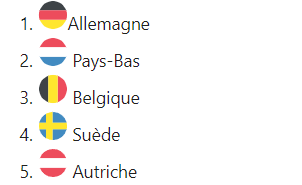

**Le Royaume-Uni a été retiré car suite au Brexit, les échanges commerciaux sont plus compliqués. L'Italie a également été retirée car elle a l'un des plus faible taux de dépendance aux importations et le revenu par habitant le plus faible.**

